<a href="https://colab.research.google.com/github/arsalanmubeen/IBA/blob/main/Bayesianinference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baysean -ML-2 assignment:
Dear students, 

You are required to develop an Python template for Bayesian inference based on the pymc and arviz functions. To develop this template, you need to go through the pymc and arviz APIs in detail based on all the hands-on that has been shown to you. You should develop functions for EDA/transformation, specifying prior and likelihood, sampling and the ppc part (the functions which specify what you can do with the posterior distribution outputs). You would need to add more functions which I have not taught but still very useful. Remember that you should be able to explain all the outputs of the sampling process in detail. One should be able to try out ALL the relevant parameters of a Bayesian inference problem from your template. In other words, your template should be complete. Do a dry run of your template with 100 islands example and with the estimation of the linear regression parameters.
I have uploaded all the files .

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')


from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools

from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 30)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [ ]:
def GetDatFromCSV(DataCSV):
 df = pd.read_csv(DataCSV) #'banking.csv'
 df.head(10)
 return df

In [ ]:
# Explore the target variable versus customers’ age using the stripplot function from seaborn:
def EDA(df):
 sns.stripplot(x="y", y="age", data=df, jitter=True)
 print('Explore the target variable versus customers’ age \n')
 plt.show();

 sns.stripplot(x="y", y="euribor3m", data=df, jitter=True)
 print('\n Explore the target variable versus customers’ euribor3m  \n')
 plt.show();

In [ ]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()

def LabelEncoder(df):


 df['education'] = labelencoder.fit_transform ( df['education'])
 df['job'] =       labelencoder.fit_transform ( df['job'])
 df['marital'] =   labelencoder.fit_transform ( df['marital'])
 df['default'] =   labelencoder.fit_transform ( df['default'])
 df['housing'] =   labelencoder.fit_transform ( df['housing'])
 df['loan'] =      labelencoder.fit_transform ( df['loan'])
 df['contact'] =   labelencoder.fit_transform ( df['contact'])
 df['poutcome'] =  labelencoder.fit_transform ( df['poutcome'])
 df.head(10)
 print('\n')
 df['month'].value_counts()
 df['month'] =     labelencoder.fit_transform (df['month'])
 df['day_of_week']=labelencoder.fit_transform (df['day_of_week'])
 print('\n')
 df.head(10)
 return df


In [ ]:
def correlation(df):
 print('correlation inbetween Variables \n')
 outcome = df['y']
 data = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'euribor3m']]
 data['outcome'] = outcome
 print(data.corr()['outcome'].sort_values(ascending=False))
 return data

In [ ]:
#Lets start with duration only

#Centering the data can help with the sampling.

#One of the deterministic variables θ is the output of the logistic function applied to the μ variable.

#Another deterministic variables bd is the boundary function.

#pm.math.sigmoid is the Theano function with the same name#
def  priorDistribution(simple ,x_nn = 'duration'): 
 y_simple = simple # data['outcome']
 x_n = x_nn # 'duration' 
 x_0 = data[x_n].values
 x_c = x_0 - x_0.mean()

 with pm.Model() as model_simple:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=y_simple)

    trace_simple = pm.sample(1000, tune=1000)
 return trace_simple,x_c,x_n,y_simple,x_0,model_simple

In [ ]:
def trace_simple_CHK(trace_simple,data,x_c,x_n,y_simple,x_0,model_simple):
 theta = trace_simple['θ'].mean(axis=0)
 idx = np.argsort(x_c)
 plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
 plt.vlines(trace_simple['bd'].mean(), 0, 1, color='k')
 bd_hpd = az.hdi(trace_simple['bd'])
 plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

 plt.scatter(x_c, np.random.normal(y_simple, 0.02),
            marker='.', color=[f'C{x}' for x in y_simple])
 az.plot_hdi(x_c, trace_simple['θ'], color='C2')

 plt.xlabel(x_n)
 plt.ylabel('θ', rotation=0)
 locs, _ = plt.xticks()
 plt.xticks(locs, np.round(locs + x_0.mean(), 1));  


 print('\n Sampling the α & β \n')
 print( az.summary(trace_simple, var_names=['α', 'β']))

 print('\n  Let’s run a posterior predictive check to explore how well our model captures the data.') 
 print(' We can let PyMC3 do the hard work of sampling from the posterior for us \n')
 ppc = pm.sample_posterior_predictive(trace_simple, model=model_simple, samples=500)
 preds = np.rint(ppc['y_1'].mean(axis=0)).astype('int')
 print('Accuracy of the simplest model:', accuracy_score(preds, data['outcome']))
 print('f1 score of the simplest model:', f1_score(preds, data['outcome']))

 print('\n \n \n ')
 plt.figure(figsize=(15, 15))
 corr = data.corr() 
 mask = np.tri(*corr.shape).T 
 sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis');
 print('\n poutcome & previous have a high correlation, we can simply remove one of them -  remove poutcome.')
 print('There are not many strong correlations with the outcome variable. The highest positive correlation is 0.41. \n')

In [ ]:
def lm_full(trace, age, education, marital):
    shape = np.broadcast(age, education, marital).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age/10., education, marital]])
    
    return 1 / (1 + np.exp(-(trace['Intercept'] + 
                             trace['age']*x_norm[0] + 
                             trace['age2']*(x_norm[0]**2) +
                             trace['education']*x_norm[1] +
                             trace['marital']*x_norm[2])))


In [ ]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('outcome ~ age + job + marital + education + default + housing + loan + contact + month + day_of_week + duration + campaign + pdays + previous + euribor3m ' + ' '.join(['+ np.power(age,{})'.format(j)
                                     for j in range(2,k+1)])).strip()



Explore the target variable versus customers’ age 



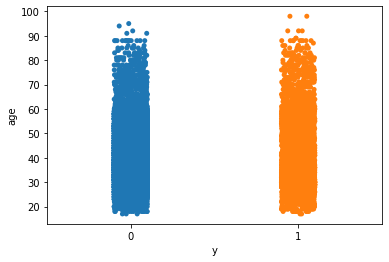


 Explore the target variable versus customers’ euribor3m  



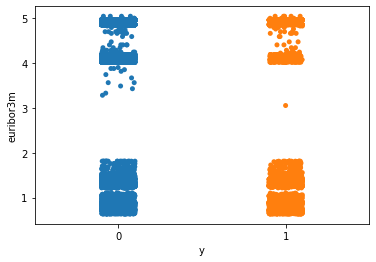





correlation inbetween Variables 

outcome        1.000000
duration       0.405274
previous       0.230181
poutcome       0.129789
education      0.057799
marital        0.046203
age            0.030399
job            0.025122
day_of_week    0.015967
housing        0.011552
loan          -0.004909
month         -0.006065
campaign      -0.066357
default       -0.099352
contact       -0.144773
euribor3m     -0.307771
pdays         -0.324914
Name: outcome, dtype: float64


In [ ]:
df = GetDatFromCSV('banking.csv')
EDA(df)
df = LabelEncoder(df)
data = correlation(df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 121 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.



 Sampling the α & β 

    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α -2.349  0.019  -2.381   -2.312        0.0      0.0    1511.0    1455.0   
β  0.004  0.000   0.004    0.004        0.0      0.0    1431.0    1278.0   

   r_hat  
α    1.0  
β    1.0  

  Let’s run a posterior predictive check to explore how well our model captures the data.
 We can let PyMC3 do the hard work of sampling from the posterior for us 



Accuracy of the simplest model: 0.8932698844323589
f1 score of the simplest model: 0.2576832151300237

 
 
 

 poutcome & previous have a high correlation, we can simply remove one of them -  remove poutcome.
There are not many strong correlations with the outcome variable. The highest positive correlation is 0.41. 



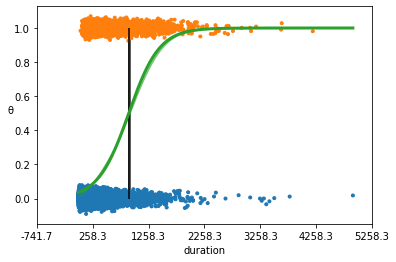

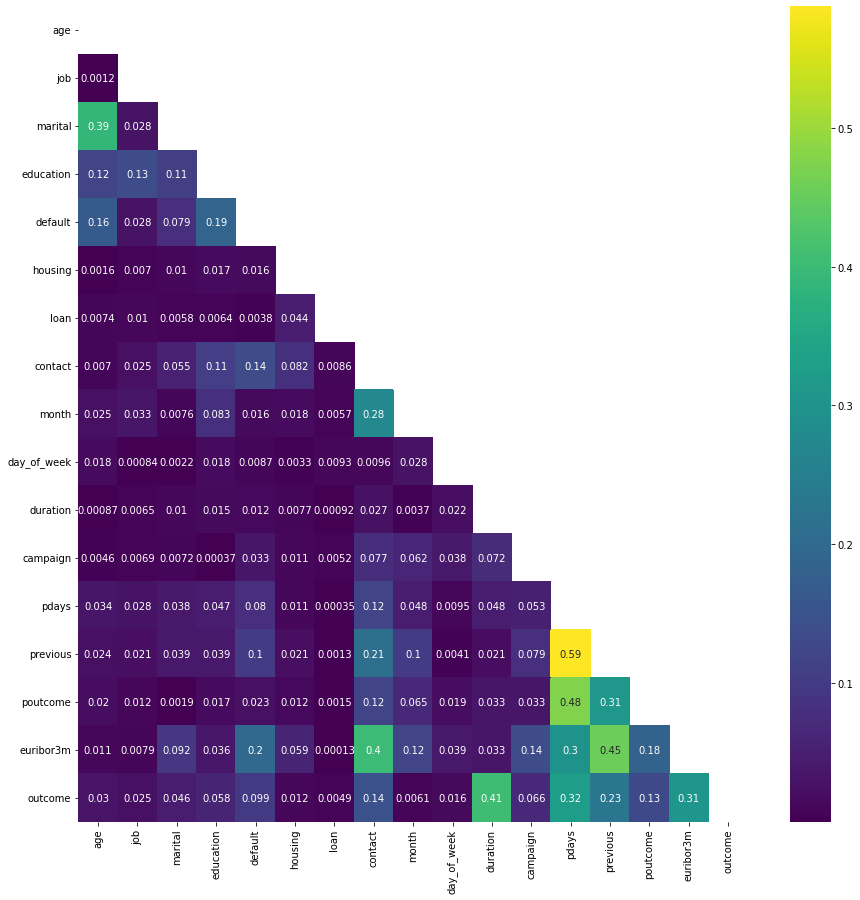

In [ ]:
trace_simple, x_c, x_n, y_simple, x_0, model_simple  =   priorDistribution(data['outcome'],'duration') 
trace_simple_CHK(trace_simple, data, x_c, x_n, y_simple, x_0, model_simple)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age2, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3266 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


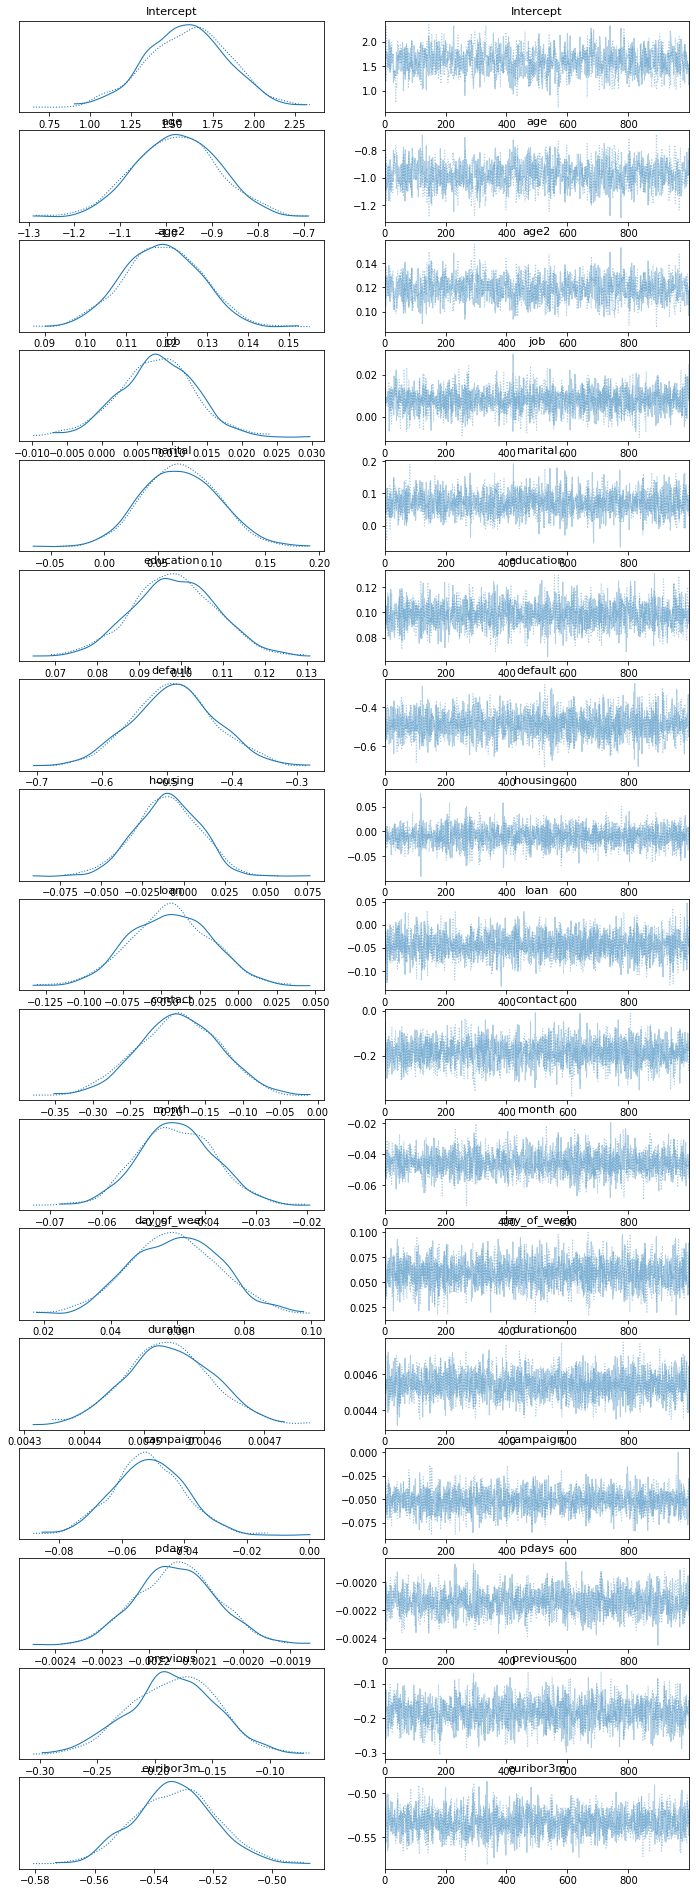

In [ ]:
 data['age'] = data['age'] / 10
 data['age2'] = np.square(data['age'])

 with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('outcome ~ age + age2 + job + marital + education + default + housing + loan + contact + month + day_of_week + duration + campaign + pdays + previous + euribor3m', data, family = pm.glm.families.Binomial())
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag')
    
 az.plot_trace(trace);

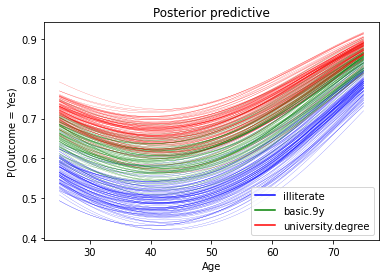

In [ ]:
def lm_full(trace, age, education, marital):
    shape = np.broadcast(age, education, marital).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age/10., education, marital]])
    
    return 1 / (1 + np.exp(-(trace['Intercept'] + 
                             trace['age']*x_norm[0] + 
                             trace['age2']*(x_norm[0]**2) +
                             trace['education']*x_norm[1] +
                             trace['marital']*x_norm[2])))

lm = lambda x, samples: lm_full(samples, x, 1., 4.)
lm2 = lambda x, samples: lm_full(samples, x, 5., 4.)
lm3 = lambda x, samples: lm_full(samples, x, 8., 4.)

pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm, samples=100, color='blue', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm2, samples=100, color='green', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm3, samples=100, color='red', alpha=.8)

blue_line = mlines.Line2D(['lm'], [], color='b', label='illiterate')
green_line = mlines.Line2D(['lm2'], [], color='g', label='basic.9y') 
red_line = mlines.Line2D(['lm3'], [], color='r', label='university.degree')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Outcome = Yes)")
plt.xlabel("Age")
plt.show();

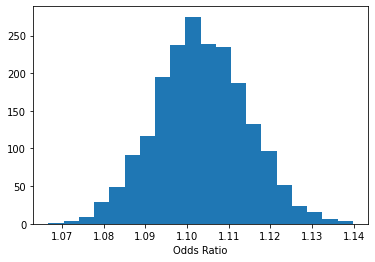

In [ ]:
b = trace['education']
plt.hist(np.exp(b), bins=20)
plt.xlabel("Odds Ratio")
plt.show();

In [ ]:
#We are 95% confident that the odds ratio of education lies within the following interval.
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
print("P(%.3f < Odds Ratio < %.3f) = 0.95" % (np.exp(lb), np.exp(ub)))

P(1.082 < Odds Ratio < 1.125) = 0.95


In [ ]:
stat_df = pm.summary(trace)
stat_df['odds_ratio'] = np.exp(stat_df['mean'])
stat_df['percentage_effect'] = 100 * (stat_df['odds_ratio'] - 1)
stat_df

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,odds_ratio,percentage_effect
Intercept,1.597,0.251,1.091,2.036,0.010,0.007,660.0,1090.0,1.00,4.938196,393.819559
age,-0.977,0.092,-1.145,-0.804,0.003,0.002,868.0,1072.0,1.01,0.376439,-62.356128
age2,0.119,0.010,0.100,0.136,0.000,0.000,938.0,1195.0,1.01,1.126370,12.636992
job,0.008,0.005,-0.002,0.018,0.000,0.000,2220.0,1409.0,1.00,1.008032,0.803209
marital,0.071,0.035,0.002,0.132,0.001,0.001,1830.0,1412.0,1.00,1.073581,7.358123
education,0.098,0.010,0.079,0.116,0.000,0.000,2324.0,1337.0,1.00,1.102963,10.296279
default,-0.489,0.065,-0.608,-0.363,0.001,0.001,2591.0,1381.0,1.01,0.613239,-38.676067
housing,-0.010,0.020,-0.050,0.022,0.000,0.000,2791.0,1100.0,1.00,0.990050,-0.995017
loan,-0.044,0.027,-0.093,0.006,0.001,0.000,2391.0,1481.0,1.00,0.956954,-4.304604
contact,-0.186,0.055,-0.284,-0.078,0.001,0.001,2028.0,1345.0,1.00,0.830274,-16.972641


In [ ]:
models_lin, traces_lin = run_models(data, 3)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/



Running: k1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1456 seconds.
The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/



Running: k2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [np.power(age, 2), euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2793 seconds.
The acceptance probability does not match the target. It is 0.8811559675465055, but should be close to 0.8. Try to increase the number of tuning steps.
The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/



Running: k3


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [np.power(age, 3), np.power(age, 2), euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10240 seconds.
The acceptance probability does not match the target. It is 0.8809385740764808, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
# We should prefer the model(s) with lower WAIC.
#The second convenience function takes the output of compare and produces a summary plot.
model_trace_dict = dict()
for nm in ['k1', 'k2', 'k3']:
    models_lin[nm].name = nm
    model_trace_dict.update({models_lin[nm]: traces_lin[nm]})
dfwaic = pm.compare(model_trace_dict, ic='WAIC')
dfwaic

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
"Intercept ~ Flat\n age ~ Normal\n job ~ Normal\n marital ~ Normal\n education ~ Normal\n default ~ Normal\n housing ~ Normal\n loan ~ Normal\n contact ~ Normal\n month ~ Normal\n day_of_week ~ Normal\n duration ~ Normal\n campaign ~ Normal\n pdays ~ Normal\n previous ~ Normal\n euribor3m ~ Normal\nnp.power(age, 2) ~ Normal\nnp.power(age, 3) ~ Normal\n y ~ Binomial",0,-9131.876973,20.470474,0.000000,0.897078,113.571379,0.000000,False,log
"Intercept ~ Flat\n age ~ Normal\n job ~ Normal\n marital ~ Normal\n education ~ Normal\n default ~ Normal\n housing ~ Normal\n loan ~ Normal\n contact ~ Normal\n month ~ Normal\n day_of_week ~ Normal\n duration ~ Normal\n campaign ~ Normal\n pdays ~ Normal\n previous ~ Normal\n euribor3m ~ Normal\nnp.power(age, 2) ~ Normal\n y ~ Binomial",1,-9143.353937,19.260377,11.476964,0.062626,113.517617,5.413020,False,log
Intercept ~ Flat\n age ~ Normal\n job ~ Normal\n marital ~ Normal\n education ~ Normal\n default ~ Normal\n housing ~ Normal\n loan ~ Normal\n contact ~ Normal\n month ~ Normal\nday_of_week ~ Normal\n duration ~ Normal\n campaign ~ Normal\n pdays ~ Normal\n previous ~ Normal\n euribor3m ~ Normal\n y ~ Binomial,2,-9221.250342,18.393643,89.373369,0.040296,113.646278,14.209024,False,log


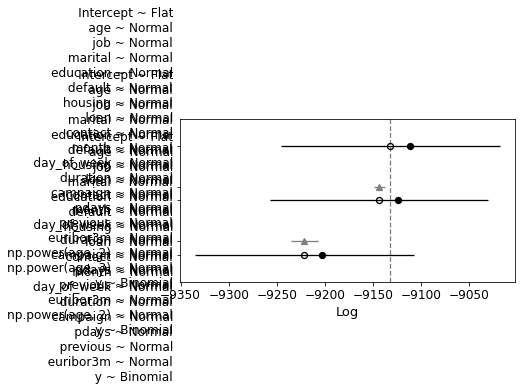

In [ ]:
# We should prefer the model(s) with lower WAIC.
pm.compareplot(dfwaic);

Confusion matrix
[[35636   912]
 [ 2884  1756]]


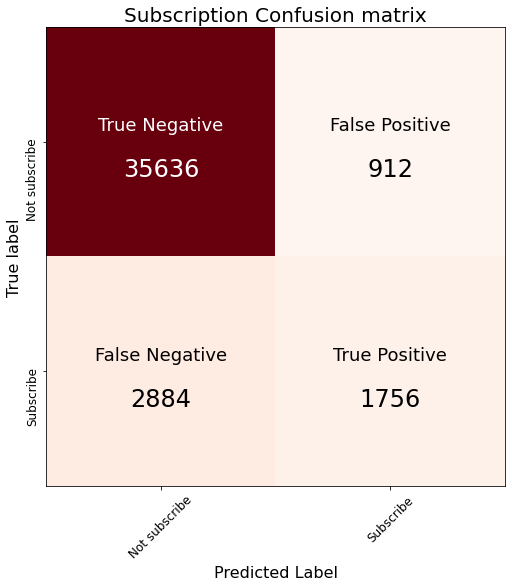

In [ ]:
ppc = pm.sample_posterior_predictive (trace, model=logistic_model, samples=500)
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')

def plot_confusion_matrix(cm, classes = ['Not subscribe', 'Subscribe'],
                          title='Subscription Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    figsize(8, 8)
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)
    
cm = confusion_matrix(data['outcome'], preds)
plot_confusion_matrix(cm)

In [ ]:
print('Accuracy of the full model: ', accuracy_score(preds, data['outcome']))
print('f1 score of the full model: ', f1_score(preds, data['outcome']))

Accuracy of the full model:  0.9078372341458677
f1 score of the full model:  0.48056923918992883
